# Inference: Covariance Adaptive Slice Sampling - Rank Shrinking
This example shows you how to perform Bayesian inference on a Gaussian distribution and a time-series problem, using
Covariance Adaptive Slice Sampling with Rank Shrinking.

First, we create a simple normal distribution.

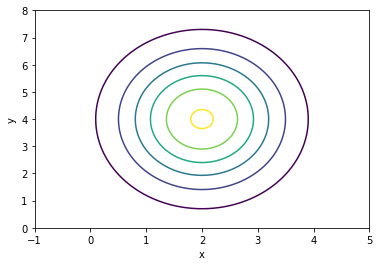

In [16]:
import os
os.chdir("../")
import pints
import pints.toy
import numpy as np
import matplotlib.pyplot as plt

# Create log pdf
log_pdf = pints.toy.GaussianLogPDF([2, 4], [[1, 0], [0, 3]])

# Contour plot of pdf
levels = np.linspace(-3,12,20)
num_points = 100
x = np.linspace(-1, 5, num_points)
y = np.linspace(-0, 8, num_points)
X, Y = np.meshgrid(x, y)
Z = np.zeros(X.shape)
Z = np.exp([[log_pdf([i, j]) for i in x] for j in y])
plt.contour(X, Y, Z)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [17]:
# Choose starting point for 3 mcmc chains
xs = [
    [2, 4],
    [3, 3],
    [5, 4],
]

# Create mcmc routine
mcmc = pints.MCMCController(log_pdf, 3, xs, method=pints.SliceShrinkRankMCMC)

# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(5)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling, Covariance Adaptive: Rank Shrinking
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     12      0:00.0
2     20      0:00.0
3     31      0:00.0
1000  11970   0:04.7
2000  23776   0:09.7
3000  35462   0:15.4
4000  47165   0:23.0
5000  59141   0:28.5
6000  70670   0:35.1
7000  82403   0:41.0
8000  94338   0:47.1
9000  106098   0:53.0
10000 118293   0:58.9
Halting: Maximum number of iterations (10000) reached.
Done!


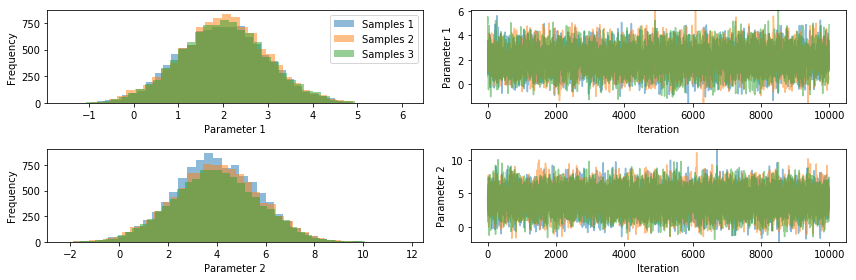

In [18]:
# Show traces and histograms
import pints.plot
pints.plot.trace(full_chains)
plt.show()

R-hat:
[1.0001053898074168, 1.0000354962082993]
0.0009498336024917897
0.0005532854493535133
0.0006881183811009439


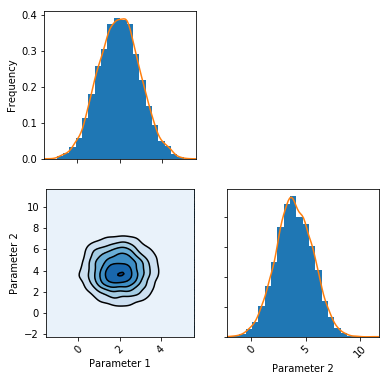

In [19]:
# Discard warm up
chains = full_chains[:, 200:]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(chains))

# Check Kullback-Leibler divergence of chains
print(log_pdf.kl_divergence(chains[0]))
print(log_pdf.kl_divergence(chains[1]))
print(log_pdf.kl_divergence(chains[2]))

# Look at distribution in chain 0
pints.plot.pairwise(chains[0], kde=True)
plt.show()

# Slice Sampling with Covariance Adaptive: Rank Shrinking on a time-series problem
We now try the same method on a time-series problem

In [ ]:
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.GaussianLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [0.01, 400, noise * 0.1],
    [0.02, 600, noise * 100],
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Choose starting points for 3 mcmc chains
num_chains = 3
xs = [
    real_parameters * 1.1,
    real_parameters * 0.9,
    real_parameters * 1.15,
]

# Create mcmc routine
mcmc = pints.MCMCController(
    log_posterior, num_chains, xs, method=pints.SliceShrinkRankMCMC)

for sampler in mcmc.samplers():
    sampler.set_sigma_c(10)
    
# Add stopping criterion
mcmc.set_max_iterations(10000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(1000)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Slice Sampling, Covariance Adaptive: Rank Shrinking
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     63      0:00.1
2     175     0:00.1


/Users/lorcandelaney/Desktop/pints/pints/_log_likelihoods.py:476: RuntimeWarning: invalid value encountered in log
  - np.sum(error**2, axis=0) / (2 * sigma**2))
/Users/lorcandelaney/Desktop/pints/pints/toy/_logistic_model.py:70: RuntimeWarning: overflow encountered in exp
  exp = np.exp(-r * times)
/Users/lorcandelaney/Desktop/pints/pints/toy/_logistic_model.py:77: RuntimeWarning: overflow encountered in multiply
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/Users/lorcandelaney/Desktop/pints/pints/toy/_logistic_model.py:77: RuntimeWarning: overflow encountered in square
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/Users/lorcandelaney/Desktop/pints/pints/toy/_logistic_model.py:77: RuntimeWarning: invalid value encountered in true_divide
  dvalues_dp[:, 0] = k * times * c * exp / (c * exp + 1)**2
/Users/lorcandelaney/Desktop/pints/pints/toy/_logistic_model.py:79: RuntimeWarning: overflow encountered in square
  (self._p0 * (c * exp + 1)**2) + 1 / (c * exp 

3     415     0:00.4


R-hat:
[1.1648559365006566, 1.1681184066911652, 1.1178988132304344]


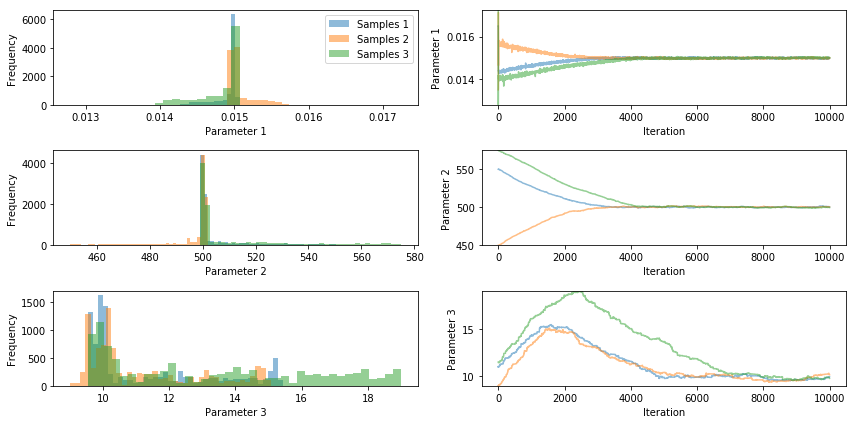

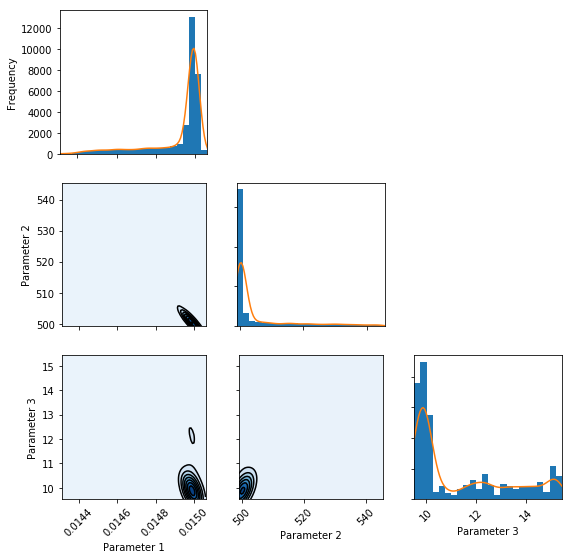

In [23]:
# Show traces and histograms
pints.plot.trace(full_chains)

# Discard warm up
full_chains = full_chains[:, 200:, :]

# Check convergence using rhat criterion
print('R-hat:')
print(pints.rhat_all_params(full_chains))

# Look at distribution in chain 0
pints.plot.pairwise(full_chains[0], kde=True)

# Show graphs
plt.show()